# Creation of the Evaluation data for TrOCR

In [2]:
pip install python-dwca-reader

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.10/install/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import requests
import shutil
import os
import time
import math
import pandas
import json
from tqdm import tqdm
import glob
import random
from PIL import Image
import imghdr
from sklearn.model_selection import train_test_split
# Multiprocessing stuff
import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

# Some CV/DL module
import numpy as np
np.__version__
import matplotlib.pyplot as plt
import cv2


from dwca.read import DwCAReader
from dwca.darwincore.utils import qualname as qn

In [11]:
# Some hyper-parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './data'
width=256
height=256
depth=3


timestr = time.strftime("%Y%m%d-%H%M%S")
DATASET_CSV = "//projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv"
DATASET_PATH = org_img_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/20220616-061434/"	# "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/"
craft_res_dir = org_img_dir.replace('/scraped-data/', '/CRAFT-results/')
seg_img_dir = org_img_dir.replace('/scraped-data/', '/seg-results/')

PERCENT_TO_SCRAPE = 0.0007
#PERCENT_TO_SCRAPE = 0.01252703
NUMBER_TO_SKIP = 0
OUTPUT_PATH = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/" + timestr + "/"
TEXT_PATH = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/"
OUTPUT_PATH_IMAGES = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/images/" + timestr + "/"
DATASET_URL = "https://occurrence-download.gbif.org/occurrence/download/request/0196625-210914110416597.zip"
DATASET_TYPE = ""


Note: There are 7,982,741 images avaialble in GBIF database, but we only scrapped 1198 images for evaluation purpose. If you want to see the amount of data that we have, use the following code, or you can checkout the 'scraping' folder to scrape more data from the website.

```python
# If you want to read the data from that data.csv file
import pandas as pd
df = pd.read_csv(DATASET_PATH + DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")
```



## Converting the CSV data into a pandas data frame

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv(DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")

colnames: ['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality', 'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day', 'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue']
df.shape: (7982741, 50)


In [6]:
df = df.sort_values(by='species')

In [18]:
print(df)

             gbifID                            datasetKey  \
6228346  1638360008  b89a7f02-021d-4e7a-b19f-575d10578a6d   
3741256  2575063623  861e6afe-f762-11e1-a439-00145eb45e9a   
1399147  2575095083  861e6afe-f762-11e1-a439-00145eb45e9a   
7010070  1839572480  b740eaa0-0679-41dc-acb7-990d562dfa37   
7274512  1839572446  b740eaa0-0679-41dc-acb7-990d562dfa37   
...             ...                                   ...   
7982097  2827740321  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982159  2829738120  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982199  2827779665  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982445  2830037097  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982475  2828714677  07a54454-87c7-4e1e-b2ba-88a9d98d534b   

                                              occurrenceID  kingdom  \
6228346                                                NaN  Plantae   
3741256               781823f5-aab8-4cd8-b4c8-1578289c842a  Plantae   
1399147               d3a05336-37b2-468d-9973-3e15e3e7

## Taking a look at the data csv

In [15]:
df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,2417026544,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027832,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.119Z,StillImage,DIFFERENT_OWNER_INSTITUTION
1,2417026527,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027833,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.120Z,StillImage,DIFFERENT_OWNER_INSTITUTION
2,2458329530,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003877,Plantae,Tracheophyta,Liliopsida,Alismatales,Hydrocharitaceae,Elodea,Elodea canadensis,...,Identified by the collector,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,S.S. Ganeshin,NaN,NaN,2022-03-25T12:48:46.136Z,StillImage,DIFFERENT_OWNER_INSTITUTION
3,2417025838,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027817,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.142Z,StillImage,DIFFERENT_OWNER_INSTITUTION
4,2458328836,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003842,Plantae,Tracheophyta,Liliopsida,Alismatales,Butomaceae,Butomus,Butomus umbellatus,...,Chernyakovskaya-Reyneke,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Chernyakovskaya-Reyneke,NaN,NaN,2022-03-25T12:48:46.168Z,StillImage,DIFFERENT_OWNER_INSTITUTION


## Looking at the most represented genus' in our data

In [7]:
x = df['genus'].value_counts()
#y = df.pivot(index='genus', columns='species', values=x)
print(f"We have {len(x)} genus in total!")
x[:250]

We have 15462 genus in total!


Carex           228853
Salix            78596
Euphorbia        60624
Juncus           57851
Viola            49885
                 ...  
Sisyrinchium      5726
Spiranthes        5633
Mikania           5629
Ulmus             5612
Rhynchosia        5599
Name: genus, Length: 250, dtype: int64

## Extracting the ID values from the dataframe and storing it into a dictionary 'data'

In [8]:

data = {}

NUMBER_TO_SKIP = math.floor(df.shape[0] / (df.shape[0] * PERCENT_TO_SCRAPE))

NUMBER_TO_SCRAPE = math.ceil(df.shape[0] / NUMBER_TO_SKIP) #79
print(str(NUMBER_TO_SCRAPE) + " IDs will be scraped.")
for i in range(1, df.shape[0], NUMBER_TO_SKIP):
#for i in range(1, NUMBER_TO_SCRAPE, NUMBER_TO_SKIP):
    if DATASET_TYPE == "dwca":
        id = df.at[i, "id"]
    elif DATASET_TYPE == "csv":
        id = df.at[i, "gbifID"]
    data[i] = {"id": str(id)}
print("Successfully scraped " + str(len(data)) + " IDs.")


5591 IDs will be scraped.
Successfully scraped 5591 IDs.


## Scrape the data using GBIF API and extract the image URL, taxon, country, Collector information

In [9]:
#code to manually delete the data for corrupted or missing values, if required
#del data[next(islice(data, 990, None))] 
from itertools import islice




print("Data will be fetched for", len(data), "occurrences.")


def scrape_occurrence(key):
    rq = requests.get("https://api.gbif.org/v1/occurrence/" + str(data[key]["id"]))
    return_dict = {}
    return_dict[key] = {}
    
    if 'media' in json.loads(rq.content):
        if not json.loads(rq.content)["media"]: #checking for empty list
        #print(json.loads(rq.content)["media"][0].keys())
            return None
        else:
            if 'identifier' in json.loads(rq.content)["media"][0]:
                return_dict[key]["img_url"] = json.loads(rq.content)["media"][0]["identifier"]
            else:
                return None
    else:
        return None
        #return_dict[key]["img_url"] = "NAN"
    
    if 'format' in json.loads(rq.content)["media"][0]:
        return_dict[key]["img_type"] = json.loads(rq.content)["media"][0]["format"]
    else:
        return None   
    
    
    if 'country' in json.loads(rq.content):
        return_dict[key]["country"] = json.loads(rq.content)["country"]
    else:
        return None
    
    if 'genus' in json.loads(rq.content):
        return_dict[key]["genus"] = json.loads(rq.content)["genus"]
    else:
        return None
        #return_dict[key]["genus"] = "NAN"
    
    if 'species' in json.loads(rq.content):
        return_dict[key]["species"] = json.loads(rq.content)["species"]
    else:
        return None
    
    if 'recordedBy' in json.loads(rq.content):
        return_dict[key]["Collector"] = json.loads(rq.content)["recordedBy"]
    else:
        return None
    
    #print(return_dict)
    return return_dict

scrape = {}
print("Starting multiprocessing...")
pool = mp.Pool(NUM_CORES)
print("Fetching data...")
#index = 1
for item in tqdm(pool.imap(scrape_occurrence, data), total=len(data)):
    if item==None:
        pass
    else:
        scrape.update(item)
    
pool.close()
pool.join()

print("\nSuccessfully fetched data for", len(scrape), "occurrences.")

# for values in scrape.values(): 
#    print(values)


Data will be fetched for 5586 occurrences.
Starting multiprocessing...


  0%|          | 0/5586 [00:00<?, ?it/s]

Fetching data...


 31%|███       | 1731/5586 [00:32<01:12, 53.35it/s]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
for values in scrape.values(): 
   print(values)

## Showing the spread of the evaluation data and the frequencies of the higher populated genera

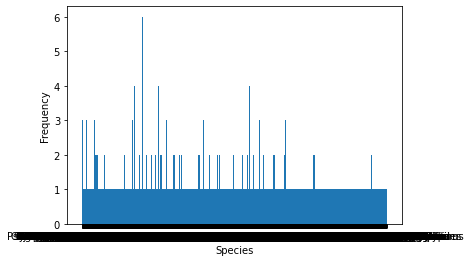

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Access the species values from the 'scrape' dictionary
species_list = [scrape[key]["species"] for key in scrape]

# Count the frequency of each species
species_freq = dict(Counter(species_list))

# Plot a histogram of the species values
plt.hist(species_list, bins=len(species_freq))
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.show()

In [9]:
species_count = {}
for species, freq in species_freq.items():
    if freq in [6, 5, 4, 3]:
        species_count[species] = freq

print("Number of species with 6, 5, 4, and 3 occurrences:", len(species_count))
print(species_count)

Number of species with 6, 5, 4, and 3 occurrences: 109
{'Crepis paludosa': 3, 'Drosera rotundifolia': 4, 'Eriosema psoraleoides': 3, 'Viola pubescens': 3, 'Calamagrostis canadensis': 3, 'Solanum nigrum': 3, 'Lemna trisulca': 3, 'Viola adunca': 3, 'Rosa carolina': 3, 'Plagiomnium cuspidatum': 3, 'Gaylussacia baccata': 3, 'Tsuga canadensis': 3, 'Hypopitys monotropa': 3, 'Crataegus macrosperma': 4, 'Melilotus albus': 3, 'Tilia americana': 3, 'Ceratophyllum demersum': 3, 'Atriplex canescens': 3, 'Drosera intermedia': 3, 'Carex aquatilis': 3, 'Trisetum spicatum': 3, 'Photinia floribunda': 3, 'Rumex crispus': 3, 'Salix exigua': 3, 'Symphyotrichum pilosum': 3, 'Fagus grandifolia': 3, 'Vicia cracca': 5, 'Cystopteris fragilis': 3, 'Cercocarpus montanus': 3, 'Achillea millefolium': 3, 'Agrostis capillaris': 3, 'Osmunda regalis': 4, 'Potamogeton gramineus': 3, 'Hackelia deflexa': 3, 'Mentha longifolia': 3, 'Ranunculus peltatus': 4, 'Carex disticha': 3, 'Androsace septentrionalis': 5, 'Micranthes 

## Downloading the images and storing them along with Country, Collector and Taxon information

In [23]:
from time import sleep
import requests
import shutil
import multiprocessing as mp
import os
from functools import partial

def download(key):
    try:
        img = requests.get(scrape[key]["img_url"], stream=True, timeout=10)
        with open(
            OUTPUT_PATH_IMAGES + str(key) + "." + scrape[1]["img_type"].split("/", 1)[1], "wb"
        ) as f:
            shutil.copyfileobj(img.raw, f)
        return True, key
    except:
        return False, key

data = scrape.copy()

if not os.path.exists(OUTPUT_PATH_IMAGES):
    os.makedirs(OUTPUT_PATH_IMAGES)

print("Starting multiprocessing...")
pool = mp.Pool(NUM_CORES)
print("Downloading images...")
    #func = partial(download, data=data)
    #errorCount = 0
errorKeys = []
for success, key in tqdm(pool.map(download, scrape), total=len(scrape)):
    if success == False:
        errorKeys.append(key)
pool.close()
pool.join()
for key in errorKeys:
    del scrape[key]
    ## Loop to reindex downloaded images sequentially
    # for count, filename in enumerate(os.listdir(OUTPUT_PATH)):
    #     new = str(count) + "." + filename.split(".")[1]  # new file name
    #     src = os.path.join(OUTPUT_PATH, filename)  # file source
    #     dst = os.path.join(OUTPUT_PATH, new)  # file destination
    #     # rename all the file
    #     os.rename(src, dst)
print("\nSuccessfully downloaded", len(scrape), "images")




Starting multiprocessing...


100%|██████████| 4447/4447 [00:00<00:00, 2269384.34it/s]



Successfully downloaded 4183 images


In [31]:
image_folder = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/images/20230327-145405/"

# Get the list of image files in the folder
image_files = os.listdir(image_folder)

# Iterate over the dictionary keys and check if the corresponding image file exists
missing_keys = []
for key in data.keys():
    image_filename = str(key) + '.jpg'
    if image_filename not in image_files:
        missing_keys.append(key)
print(f"based on image names we get {len(missing_keys)} keys that had a download failure.")
print("error keys: ",len(errorKeys))
manual_deletion = [key for key in errorKeys if key not in missing_keys]
print("manually delete these images from the created images folder if any due to multiprocess issues: ",manual_deletion)

based on image names we get 264 keys that had a download failure.
error keys:  264
manually delete these images from the created images folder:  []


In [33]:
with open(TEXT_PATH + "countries.txt", "w") as f:
    for idx in scrape:
        f.write(scrape[idx]["country"] + "\n")
print("\nSuccessfully wrote countries to file.")


Successfully wrote countries to file.


In [34]:
with open(TEXT_PATH + "taxon.txt", "w") as f:
    for idx in scrape:
        f.write(scrape[idx]["genus"] + " " + scrape[idx]["species"] + "\n")
print("\nSuccessfully wrote taxon to file.")


Successfully wrote taxon to file.


In [35]:
with open(TEXT_PATH + "collector.txt", "w") as f:
    for idx in scrape:
        f.write(scrape[idx]["Collector"] + "\n")
print("\nSuccessfully wrote collector to file.")


Successfully wrote collector to file.


## Regenerating only the subset of the GBIF data that we have scraped and storing it as a CSV

In [18]:
image_folder = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/images/20230327-145405/"
#get the file names from the folder of extracted images, where the file names are the keys to the GBIF dataset
file_names = sorted(os.listdir(image_folder), key=lambda x: int(x.split('.')[0])) 
keys = [file.split('.')[0] for file in file_names]
new_df = df.loc[df.index.map(str).isin(keys)]


In [19]:
new_df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
14995,2573245514,38df3ef2-72ea-4341-aad1-c67ac7c9f8b3,8a49aec6-2895-4d47-b832-38933dbf944f,Plantae,Bryophyta,Andreaeopsida,Andreaeales,Andreaeaceae,Andreaea,Andreaea rothii,...,NaN,NaN,CC_BY_4_0,University of Vermont,D. L. Dutton,NaN,NaN,2022-03-01T16:43:34.104Z,StillImage,INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE
16661,2573248958,38df3ef2-72ea-4341-aad1-c67ac7c9f8b3,afff22ae-b495-490c-8de0-a7eb7f3cb4ab,Plantae,Bryophyta,Bryopsida,Orthotrichales,Orthotrichaceae,Orthotrichum,Orthotrichum lyellii,...,W. M. Rooks,NaN,CC_BY_4_0,University of Vermont,J. A. Allen,NaN,NaN,2022-03-01T16:43:35.045Z,StillImage,INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE
18327,2573252650,38df3ef2-72ea-4341-aad1-c67ac7c9f8b3,9606b2df-7113-4d46-ba99-57e40ebfd5fe,Plantae,Bryophyta,Bryopsida,Bryales,Mniaceae,Rhizomnium,Rhizomnium glabrescens,...,NaN,NaN,CC_BY_4_0,University of Vermont,J. B. Flett,NaN,NaN,2022-03-01T16:43:35.645Z,StillImage,INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE
19993,2573257992,38df3ef2-72ea-4341-aad1-c67ac7c9f8b3,4619a039-2d5c-4fc4-aa3b-36700dfda9c8,Plantae,Bryophyta,Bryopsida,Pottiales,Pottiaceae,Gymnostomum,Gymnostomum aeruginosum,...,W. M. Rooks,NaN,CC_BY_4_0,University of Vermont,D. L. Dutton,NaN,NaN,2022-03-01T16:43:36.622Z,StillImage,INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE
21659,1056409769,7e380070-f762-11e1-a439-00145eb45e9a,e241e202-5a77-4844-b8b1-ab9eba33b11d,Plantae,Tracheophyta,Magnoliopsida,Cucurbitales,Cucurbitaceae,Apodanthera,Apodanthera palmeri,...,Manuel J. Belgrano,NaN,CC0_1_0,NaN,Edward Palmer,ISOTYPE,NaN,2022-03-26T14:50:49.959Z,StillImage,GEODETIC_DATUM_ASSUMED_WGS84;INSTITUTION_MATCH...


In [21]:
path= "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/Evaluation_data.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)
new_df.to_csv(path, index=True)